# Data preparation for time series models

In [1]:
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
import statsmodels.formula.api as smf
import lightgbm as lgb
import re
import optuna
import requests
from darts import TimeSeries


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import LinearRegressionModel
from darts.metrics import mae, mape, rmse

from itertools import product

from tsfresh import extract_features

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import optuna
from darts.metrics import mape, mae
from pytorch_lightning.callbacks import EarlyStopping
from darts.models import TFTModel
from darts.explainability.tft_explainer import TFTExplainer

/home/kuura/anaconda3/envs/nuwats_env/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
The StatsForecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [2]:
mun_stats = pd.read_csv("data/statfin_vaerak_pxt_11ra_municipalities.csv", index_col=0)
mun_migri = pd.read_csv("data/statfin_muutl_pxt_11a1_municipalities.csv", index_col=0)

In [3]:
pop_stats = \
    (mun_stats
     .loc[mun_stats["Information"] == "Population 31 Dec", :]
     .melt(
        id_vars=["Area", "Information"],
        var_name="year",
        value_name="Population 31 Dec")
     .drop(columns=["Information"])
     .pivot(columns="Area", index="year")
     # .astype('int')
     .describe())

In [4]:
muns_of_interest = list(pop_stats.loc[:, (pop_stats.loc[["min"]] > 10000).values[0]].columns.droplevel())
# muns_of_interest = pop_stats.loc[["min"]].transpose().reset_index().sort_values(by="min")[-10:]["Area"].values
muns_of_interest = set(muns_of_interest)

### Supplement with Sotkanet and with dwelling price data

In [5]:
indicators = {
    180: 'Measure of educational level',
    181: 'Unemployed people, as % of labour force',
    # 190: 'Household-dwelling units with children living in overcrowded conditions, as % of all households with children',
    # 191: 'Placements outside the home for those aged 0-17, as % of total population of same age (THL)',
    289: 'Heavy drinking at least once a month, as % of all pupils in 8th and 9th year of comprehensive school',
    306: 'Disability pension recipients aged 25-64, as % of total population of the same age',
    493: 'Social assistance, recipient persons during year, as % of total population',
    3105: 'Alcohol mortality per 100 000 inhabitant',
    3169: 'Parturients who smoked during pregnancy, % of parturients',
    3113: 'Offences against life and health recorded by the police per 1000 inhabitants',
    # 3219: 'Those aged 17 - 24 not in education or training, as % of total population of same age',
    3071: 'Persons who are difficult to employ (structural unemployment), as % of persons aged 15 - 64',
    3076: 'Voting turnout in municipal elections, %',
    # 4404: 'Daily smokers (%)'
    # 5333: 'Municipality employs a designated expert, planning officer or similar to coordinate health and welfare promotion'
    # 5338: 'Performance indicator average (health and welfare coefficient)'
}

years = list(range(1990, 2024))

In [6]:
# Configuration
HEADERS = {"User-Agent": "MunicipalityAnalysis/1.0"}
SOTKANET_BASE = "https://sotkanet.fi/rest/1.1/json?"

def get_sotkanet_data(indicator_ids, years):
    """Fetch data for multiple indicators from Sotkanet"""
    df_list = []
    
    for indicator_id in indicator_ids:
        url = f"{SOTKANET_BASE}indicator={indicator_id}"
        for year in years:
            url += f"&years={year}"
        url += "&genders=total"
        
        response = requests.get(url, headers=HEADERS)
        data = response.json()
        
        # Convert to DataFrame
        temp_df = pd.DataFrame(data)
        temp_df['indicator_id'] = indicator_id
        df_list.append(temp_df)
    
    final_df = pd.concat(df_list, ignore_index=True)
    return final_df

# data = get_sotkanet_data(indicators, years)


In [7]:
data = pd.read_csv("data/sotka_data.csv", index_col=0)

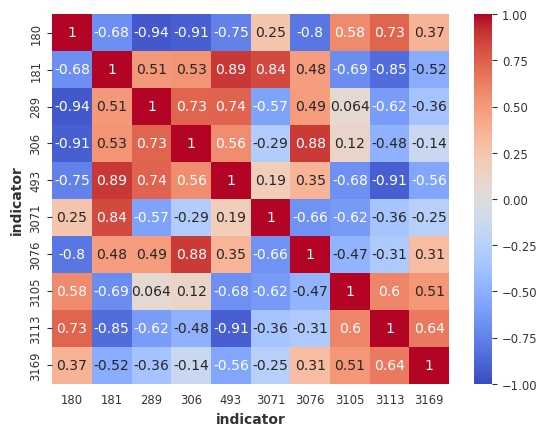

In [8]:
sotka_corr = \
    (data[["indicator", "year", "value"]]
     .pivot_table(
        index=["year"], 
        columns="indicator",
        values="value")
     .corr())

ax = sns.heatmap(sotka_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=1, yticklabels=1)

ax.grid(False);

In [9]:
# Get current municipality codes (KUNTA regions)
def get_municipality_codes():
    url = "https://sotkanet.fi/rest/1.1/regions"
    response = requests.get(url, headers=HEADERS)
    regions = pd.DataFrame(response.json())
    #  return regions[regions['category'] == 'KUNTA'][['code', 'title']]  # <- code?
    return regions[regions['category'] == 'KUNTA'][['id', 'title']]

municipalities = get_municipality_codes()
municipalities['id'] = municipalities['id'].astype('int')

In [10]:
municipalities = pd.read_csv("data/sotka_municipalities.csv", index_col=0)

In [11]:
# municipalities.to_csv("data/sotka_municipalities.csv")
# data.to_csv("data/sotka_data.csv")

In [12]:
municipalities['municipality'] = municipalities.title.map(lambda x: eval(x)['fi'])

In [13]:
# Merge with data
sotka_mun_data = data.merge(
    municipalities, 
    left_on='region', 
    right_on='id',
    how='left'
)

sotka_mun_data = sotka_mun_data.dropna(subset=['title'])
sotka_mun_data['municipality'] = sotka_mun_data.title.map(lambda x: eval(x)['fi'])
sotka_mun_data.drop(columns=['title', 'absValue'], inplace=True)

In [14]:
# sotka_mun_data.loc[(sotka_mun_data['municipality'] == 'Turku') & (sotka_mun_data['indicator'] == 180), :]

In [15]:
price_data = pd.read_csv("data/statfin_ashi_pxt_13mz.csv", index_col=0)
price_data['Region'] = price_data['Region'].str.replace('Espoo-Kauniainen', 'Espoo')

In [16]:
sotka_mun_data = sotka_mun_data[sotka_mun_data.municipality.isin(muns_of_interest)]
price_data = price_data[price_data.Region.isin(muns_of_interest)]

### Prepare net migration

In [17]:
full_data = pd.read_csv("data/full_arr_dep_stats.csv", index_col=0)


In [18]:
# Calculate total arrivals per municipality per year
arrivals = full_data.groupby(['Arrival', 'year'])['Migration'].sum().reset_index()
arrivals = arrivals.rename(columns={'Arrival': 'municipality', 'Migration': 'arrivals'})

# Calculate total departures per municipality per year
departures = full_data.groupby(['Departure', 'year'])['Migration'].sum().reset_index()
departures = departures.rename(columns={'Departure': 'municipality', 'Migration': 'departures'})

# Merge arrivals and departures
net_migration = pd.merge(arrivals, departures, on=['municipality', 'year'], how='outer').fillna(0)

# Calculate net migration
net_migration['net_migration'] = net_migration['arrivals'] - net_migration['departures']

# Sort
net_migration = net_migration.sort_values(['municipality', 'year'])


In [19]:
full_data = full_data.merge(net_migration, left_on=["Arrival", "year"], right_on=["municipality", "year"])

In [20]:
df = full_data.loc[((full_data["Arrival"].isin(muns_of_interest)) & 
                    (full_data["Departure"].isin(muns_of_interest))),  :]
df = df.loc[:, ~df.columns.str.contains('_diff|_dep')]  # Interested in Arrival mun stats only
df.drop(columns=["Area"], inplace=True)

In [21]:
sotka_wide = \
    sotka_mun_data[["indicator", "year", "value", "municipality"]].pivot(
        index=["year", "municipality"],
        values="value",
        columns="indicator"
    ).reset_index()

In [22]:
df_sotka_price = (df.merge(sotka_wide, left_on=["municipality", "year"], right_on=["municipality", "year"], how="left"))
df_sotka_price = df_sotka_price.merge(price_data, left_on=["municipality", "year"], right_on=["Region", "Year"], how="left")

# check NAs
#pd.DataFrame(df_sotka_price.groupby(['municipality', 'year'])
#             .first()
#             .groupby(['municipality'])
#             .apply(lambda g: g.isna().sum()))

In [23]:
# Normalize

df_sotka_price['net_migration'] /= df_sotka_price["Population 31 Dec_arr"]

<Axes: xlabel='net_migration', ylabel='Count'>

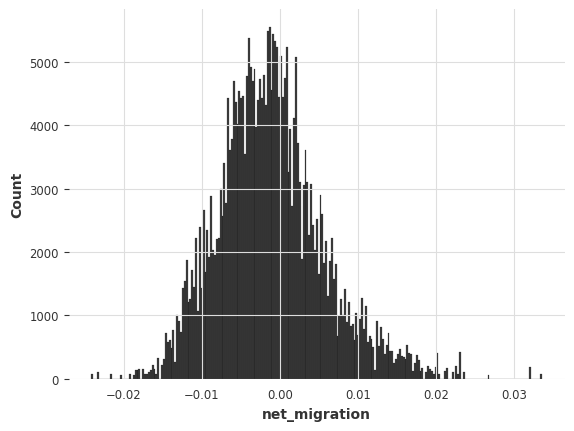

In [24]:
sns.histplot(df_sotka_price['net_migration'])

In [25]:
### take first, sum Migration

df_agg = df_sotka_price.groupby(["year", "municipality"]).first()["net_migration"]
df_agg = pd.DataFrame(df_agg).reset_index()

### Plot net migration time series

In [26]:
pivoted_df = df_agg.pivot(index='year', columns='municipality', values='net_migration')

# datetime index
pivoted_df.index = pd.to_datetime(pivoted_df.index, format='%Y')

# multivariate series
multiseries = TimeSeries.from_dataframe(pivoted_df)

In [27]:
# List some colors

color_list = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#aec7e8', '#ffbb78'
]


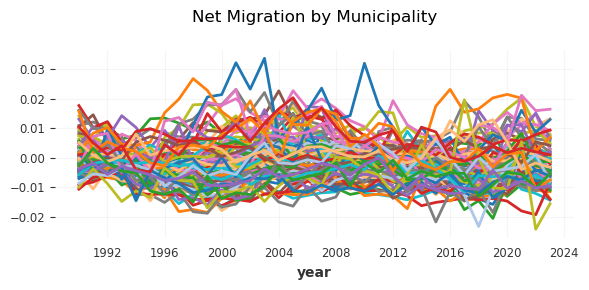

In [28]:
import matplotlib.colors as mcolors


plt.figure(figsize=(6, 3))  # Set figure size first

for idx, municipality in enumerate(pivoted_df.columns):
    #if municipality != "Helsinki":
    #    continue
    ts = TimeSeries.from_dataframe(pivoted_df[[municipality]])
    ts.plot(
        label=municipality,
        color=color_list[idx % len(color_list)],  # Loop through colors
        linewidth=2
        # marker='o'  
    )

plt.title("Net Migration by Municipality", pad=20)
plt.grid(True, alpha=0.3)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.legend('',frameon=False)
plt.tight_layout()
plt.savefig("images/net_migri_norm.png")
plt.show()

### Covariates

In [29]:
df_agg_w_stats = df_sotka_price.groupby(["municipality", "year"]).first().drop(
    columns=["Sex", "Departure", "Migration", "Region", "Year", "Arrival", "net_migration"])

df_agg_w_stats.reset_index()
df_agg_w_stats = df_agg_w_stats.merge(df_agg, on=["municipality", "year"])

static_covs = pd.get_dummies(df_agg_w_stats["municipality"], columns=["municipality"])

In [30]:
# Select numerical columns that have missing values
num_cols_with_na = [col for col in df_agg_w_stats.select_dtypes(include=np.number).columns 
                    if df_agg_w_stats[col].isna().any()]

# Fill missing values in each numerical column by Municipality-wise mean
for col in num_cols_with_na:
    df_agg_w_stats[col] = df_agg_w_stats[col].fillna(df_agg_w_stats.groupby('municipality')[col].transform('mean'))

In [31]:
# There are still NAs

num_cols_with_na = [col for col in df_agg_w_stats.select_dtypes(include=np.number).columns 
                    if df_agg_w_stats[col].isna().any()]
num_cols_with_na

[180, 181, 289, 306, 493, 3071, 3076, 3113, 3169, 'Index (2000=100)']

In [32]:
# We'd like to keep the price Index information 'Index (2000=100)'

# Group by municipality and check if all values in 'Index (2000=100)' are NaN
municipalities_all_na = df_agg_w_stats.groupby('municipality')['Index (2000=100)'].apply(lambda x: x.isna().all())

# Filter municipalities where the condition is True
municipalities_with_all_na = municipalities_all_na[municipalities_all_na].index.tolist()

print("Municipalities with all NAs in 'Index (2000=100)':")
print(municipalities_with_all_na)


Municipalities with all NAs in 'Index (2000=100)':
['Akaa', 'Alavus', 'Eura', 'Forssa', 'Hamina', 'Heinola', 'Hollola', 'Hyvinkää', 'Iisalmi', 'Ilmajoki', 'Imatra', 'Jakobstad', 'Janakkala', 'Jämsä', 'Järvenpää', 'Kaarina', 'Kalajoki', 'Kangasala', 'Kankaanpää', 'Kauhajoki', 'Kauhava', 'Kemi', 'Kerava', 'Kirkkonummi', 'Kontiolahti', 'Korsholm', 'Kurikka', 'Kuusamo', 'Lapua', 'Laukaa', 'Lempäälä', 'Lieksa', 'Lieto', 'Liperi', 'Lohja', 'Loimaa', 'Loviisa', 'Mariehamn', 'Mäntsälä', 'Naantali', 'Nivala', 'Nokia', 'Nurmijärvi', 'Orimattila', 'Pargas', 'Pieksämäki', 'Pirkkala', 'Raahe', 'Raisio', 'Riihimäki', 'Salo', 'Sastamala', 'Savonlinna', 'Siilinjärvi', 'Sipoo', 'Sotkamo', 'Tornio', 'Tuusula', 'Ulvila', 'Uusikaupunki', 'Valkeakoski', 'Varkaus', 'Vihti', 'Ylivieska', 'Ylöjärvi', 'Äänekoski']


In [33]:
# Okay, let's just remove the price data as well

df_agg_w_stats.drop(columns=num_cols_with_na, inplace=True)

assert not len([col for col in df_agg_w_stats.select_dtypes(include=np.number).columns 
                    if df_agg_w_stats[col].isna().any()])

In [34]:
df_agg_w_stats.dtypes

municipality                                                             object
year                                                                      int64
Average age, both sexes_arr                                             float64
Average age, men_arr                                                    float64
Average age, women_arr                                                  float64
Citizens of foreign countries_arr                                       float64
Demographic dependency ratio_arr                                        float64
Economic dependency ratio_arr                                           float64
Finnish speakers_arr                                                    float64
Foreign-language speakers_arr                                           float64
Increase of population_arr                                              float64
Increase of population, %_arr                                           float64
Land area, km²_arr                      

### Drop count variables

In [35]:
df_agg_w_stats = df_agg_w_stats.drop(columns=[
    'Persons with foreign background_arr',
    'Persons born abroad_arr',
    'Persons born elsewhere than in their area of residence_arr',
    'Persons born in the area belonging to the population_arr',
    'Persons born in their area of residence_arr',
    'Increase of population_arr',
    'Increase of population, %_arr',
    'Foreign-language speakers_arr',
    'Finnish speakers_arr',
    'Swedish speakers_arr',
    'Sami speakers_arr',
    'Citizens of foreign countries_arr',
    'Population 31 Dec_arr',
    'arrivals',
    'departures',  
])

In [36]:
df_agg_w_stats['Land area, km²_arr'] = np.log10(df_agg_w_stats['Land area, km²_arr'])

# df_agg_w_stats = df_agg_w_stats.loc[:, 
#     ~df_agg_w_stats.columns.str.contains('Sami')]

In [37]:
# Let's remove highly correlated if any

def remove_correlated_features(df, threshold=0.95):
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation > threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(to_drop)
    
    # Drop features
    return df.drop(columns=to_drop)
    
_df = df_agg_w_stats.drop(columns=["year", "net_migration", "municipality"])
_df = remove_correlated_features(_df)

['Average age, men_arr', 'Average age, women_arr', 'Share of Swedish speakers, %_arr', 'Share of foreign-language speakers, %_arr', 'Share of persons aged 15 to 64, %_arr', 'Share of persons aged 65 or over, %_arr', 'Share of persons born abroad, %_arr', 'Share of persons in urban areas, %_arr', 'Share of persons with foreign background , %_arr', 'Share of persons with no religious affiliation, %_arr']


In [38]:
_df["year"] = df_agg_w_stats["year"]
_df["net_migration"] = df_agg_w_stats["net_migration"]
_df["municipality"] = df_agg_w_stats["municipality"]
df_agg_w_stats = _df
df_agg_w_stats.head()

,"Average age, both sexes_arr",Demographic dependency ratio_arr,Economic dependency ratio_arr,"Land area, km²_arr",Population density_arr,"Share of Finnish speakers, %_arr","Share of foreign citizens, %_arr","Share of persons aged under 15, %_arr","Share of persons belonging to other religious groups, %_arr","Share of persons belonging to the Evangelical Lutheran Church, %_arr",...,"Share of persons in outer urban area, %_arr","Share of persons in peri-urban area, %_arr","Share of persons in rural areas close to urban areas, %_arr","Share of persons in rural areas, %_arr","Share of persons in rural heartland areas, %_arr","Share of persons in sparsely populated rural areas, %_arr","Share of persons living in the area of birth, %_arr",year,net_migration,municipality
0,38.6,52.2,130.7,2.466986,54.8,99.4,0.4,18.5,1.3,88.7,...,0.0,2.2,45.4,96.3,1.5,0.0,48.3,1990,0.005608,Akaa
1,38.8,52.7,152.3,2.466986,54.9,99.4,0.5,18.5,1.7,88.5,...,0.0,2.3,45.7,96.3,1.5,0.0,48.4,1991,0.002920,Akaa
2,38.8,53.4,171.6,2.466986,55.3,99.4,0.5,18.8,1.7,88.1,...,0.0,2.4,45.3,96.2,1.4,0.0,48.8,1992,0.005123,Akaa
3,39.1,53.8,192.3,2.466853,55.1,99.3,0.6,18.6,1.8,87.5,...,0.0,2.5,45.4,96.3,1.5,0.0,48.9,1993,-0.003593,Akaa
4,39.3,55.2,183.2,2.466853,54.7,99.3,0.6,18.9,1.8,87.1,...,0.0,2.6,45.0,96.3,1.5,0.0,48.9,1994,-0.009602,Akaa


In [39]:
df_agg_w_stats.dtypes

Average age, both sexes_arr                                             float64
Demographic dependency ratio_arr                                        float64
Economic dependency ratio_arr                                           float64
Land area, km²_arr                                                      float64
Population density_arr                                                  float64
Share of Finnish speakers, %_arr                                        float64
Share of foreign citizens, %_arr                                        float64
Share of persons aged under 15, %_arr                                   float64
Share of persons belonging to other religious groups, %_arr             float64
Share of persons belonging to the Evangelical Lutheran Church, %_arr    float64
Share of persons born in the area of residence, %_arr                   float64
Share of persons in inner urban area, %_arr                             float64
Share of persons in local centres in rur

In [40]:
# df_agg_w_stats.to_csv("data/tft_input.csv")